# Weather Changes Over Time (Consuming APIs)

## Task
Utilize the following two APIs to evaluate the changes in temperature for your birthday and city you were born in:
* [geocode.xyz](geocode.xyz)
* [open-meteo.com](open-meteo.com)


In [1]:
from datetime import date, datetime, timedelta

import requests
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline

sns.set_palette('muted')
sns.set_style('white')

## Question 1: Geocoding A Location
Write a function that utilizes the [geocode.xyz](geocode.xyz) API to take in a city and country and return the latitude and longitude of that location

```
def geocode_location(city, country):
    # your code
    return latitude, longitude
```

For example:
```
geocode_location("london", "united kingdom")
```
should return
```
(-0.11534, 51.49742)
```

In [2]:
def geocode_location(city, country):
    url = f"https://geocode.xyz/{city},{country}?geoit=json"
    r = requests.get(url)
    response = r.json()
    lat = response['latt']
    lon = response['longt']
    return lat, lon


## Question 2: Determining Weather Using Date and Location
Write a function that utilizes the [open-meteo.com](https://open-meteo.com/) API to take in a date and location and return the 15-day average high and low for the following measurements from the years 1960 to 2022:
* `precipitation_sum` (mm): Sum of daily precipitation (including rain, showers and snowfall)
* `temperature_2m_max` (°F): Maximum daily air temperature at 2 meters above ground
* `temperature_2m_min` (°F): Minimum daily air temperature at 2 meters above ground
* `apparent_temperature_max` (°F): Maximum daily apparent temperature
* `apparent_temperature_min` (°F): Min daily apparent temperature

The function should return the above measurements in a dictionary object with the keys being `"precipitation_sum"`, `"temperature_2m_max"`, etc. and the values being the 15-day average of the measurements. The 15-day average should be the 7 days preceeding the input date, the input date, and the 7 days following the input date. This will give the results more statistical validity by increasing the number of samples for each measurement.

The `get_historical_weather_measurements()` function will include a few different sub-tasks:

### Create API Request in Postman/Insomnia
Use the following [API Documentation](https://open-meteo.com/en/docs/historical-weather-api#api-documentation) page to create an API request that responds with a JSON object of the measurements listed above. Make sure the response object meets the following:
* Temperatue measurements are in Fahrenheit
* Precipitation measurements are in inches
* Measurements are daily aggregations
* 15 day range of weather
* JSON format


Before writing any code, use Postman/Insomnia to create the API request and take a screenshot of the request/response.

### Create API Request Function
Convert the request above into a function. The function should take in `latitude`, `longitude`, and `date` as its arguments and return the API response, if successful.

```
def get_api_response(latitude, longitude, date):
    # your code

```

Use the helper function below for creating a 15-day date range 

In [3]:
def get_date_range(birthday):    
    return {'start_date': birthday - timedelta(days=7),
            'end_date': birthday + timedelta(days=7)
           }

In [4]:
def get_api_response(latitude, longitude, date):
    date_range = get_date_range(date)
    start_date = date_range['start_date'].strftime("%Y-%m-%d")
    end_date = date_range['end_date'].strftime("%Y-%m-%d")
    url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&daily=temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum&temperature_unit=fahrenheit&timezone=auto"
    response = requests.get(url)
    return response.json()

### Iterating Over Each Year
Write a function that iterates through each year between 1960 and 2022 and returns the corresponding JSON response objects containing weather data for each year in a python list.

```
def get_all_response_objects(start_year, end_year):
    # your code
```


In [5]:
def get_all_response_objects(latitude, longitude, date):
    responses = []
    for year in range(1960, 2023):
        date_itr = date.replace(year=year)
        responses.append(get_api_response(latitude, longitude, date_itr))
    return responses

### Parse JSON Responses & Aggregate Data
Write a function that takes the list of JSON response objects from the previous function in as a parameter and returns a pandas DataFrame containing the original input date, the measurements, and the average across the 15 days.
```
def parse_json_response(responses):
    # your code
```


In [6]:
def parse_json_response(responses):
    year_data = []
    
    for response in responses:
        data = response
        
        max_temp = data['daily']['temperature_2m_max']
        min_temp = data['daily']['temperature_2m_min']
        max_apparent_temp = data['daily']['apparent_temperature_max']
        min_apparent_temp = data['daily']['apparent_temperature_min']
        precipitation = data['daily']['precipitation_sum']

        annual_avg_temp = sum(max_temp) / len(max_temp)
        annual_avg_precipitation = sum(precipitation) / len(precipitation)

        dates = data['daily']['time']

        for i in range(len(dates)):
            date = dates[i]
            max_temp_value = max_temp[i]
            min_temp_value = min_temp[i]
            max_apparent_temp_value = max_apparent_temp[i]
            min_apparent_temp_value = min_apparent_temp[i]
            daily_precipitation = precipitation[i]

            year_data.append([date, max_temp_value, min_temp_value, max_apparent_temp_value, min_apparent_temp_value, daily_precipitation, annual_avg_temp, annual_avg_precipitation])

    df = pd.DataFrame(year_data, columns=['date', 'max_temp (°F)', 'min_temp',
                                          'apparent_max_temp', 'apparent_min_temp',
                                          'daily_precipitation (mm)',
                                          'avg_annual_temp (°F)', 'avg_annual_precipitation (mm)'])

    return df


### Combining the Functions
Write a function that combines all the above functions into one, where the user inputs their birthday and location and the function returns the pandas DataFrame containing the summary of measurements.

```
def get_data():
    birthday = get_user_birthday()
    location = get_user_city_of_birth()
    # your code here
```

The helper functions below can be used for birthday and location input information:

In [7]:
# Helper function to get user birthday
def get_user_birthday():
    birthday = input('Enter your birthday (YYYY-MM-DD): ')
    return datetime.strptime(birthday, '%Y-%m-%d').date()

# Helper function to get user city of birth
def get_user_city_of_birth():
    city = input('Enter the city you were born in: ')
    country = input('Enter the country you were born in: ')
    return city, country

In [8]:
def get_data():
    birthday = get_user_birthday()
    lat, lon = geocode_location(*get_user_city_of_birth())
    responses = get_all_response_objects(lat, lon, birthday)
    return parse_json_response(responses)


Run your function and set it equal to `df`:

In [9]:
df = get_data()

df.head(20)

,date,max_temp (°F),min_temp,apparent_max_temp,apparent_min_temp,daily_precipitation (mm),avg_annual_temp (°F),avg_annual_precipitation (mm)
0,1960-07-17,80.9,61.1,84.6,61.5,0.5,81.400000,2.713333
1,1960-07-18,81.4,65.4,83.6,68.8,6.1,81.400000,2.713333
2,1960-07-19,80.7,61.8,83.3,64.3,2.3,81.400000,2.713333
3,1960-07-20,74.1,60.1,74.5,58.0,0.0,81.400000,2.713333
4,1960-07-21,79.6,60.2,80.5,59.2,0.0,81.400000,2.713333
5,1960-07-22,87.2,67.6,90.0,67.0,1.7,81.400000,2.713333
6,1960-07-23,82.7,67.0,85.4,68.7,3.4,81.400000,2.713333
7,1960-07-24,80.3,61.5,83.2,60.5,0.0,81.400000,2.713333
8,1960-07-25,81.3,64.2,84.0,65.7,0.0,81.400000,2.713333
9,1960-07-26,86.0,67.9,89.5,65.0,22.1,81.400000,2.713333


## Question 3: Visualizing The Data
Plot the DataFrame using `matplotlib`/`seaborn` and write a short summary of your results.

/home/WSL_Bootcamp/GrandCircusLabs/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/WSL_Bootcamp/GrandCircusLabs/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/WSL_Bootcamp/GrandCircusLabs/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


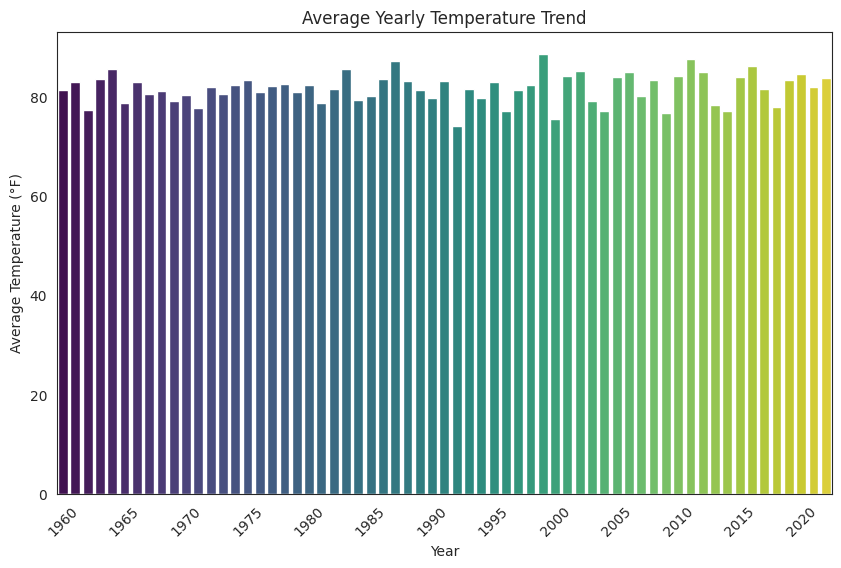

In [13]:
df['date'] = pd.to_datetime(df['date'])

df['Year'] = df['date'].dt.year

average_yearly_temp = df.groupby('Year')['avg_annual_temp (°F)'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='avg_annual_temp (°F)', data=average_yearly_temp, palette='viridis')
plt.title('Average Yearly Temperature Trend')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°F)')

step = 5
plt.xticks(range(0, len(average_yearly_temp), step), average_yearly_temp['Year'][::step], rotation=45)

plt.show()

/home/WSL_Bootcamp/GrandCircusLabs/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/WSL_Bootcamp/GrandCircusLabs/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/WSL_Bootcamp/GrandCircusLabs/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


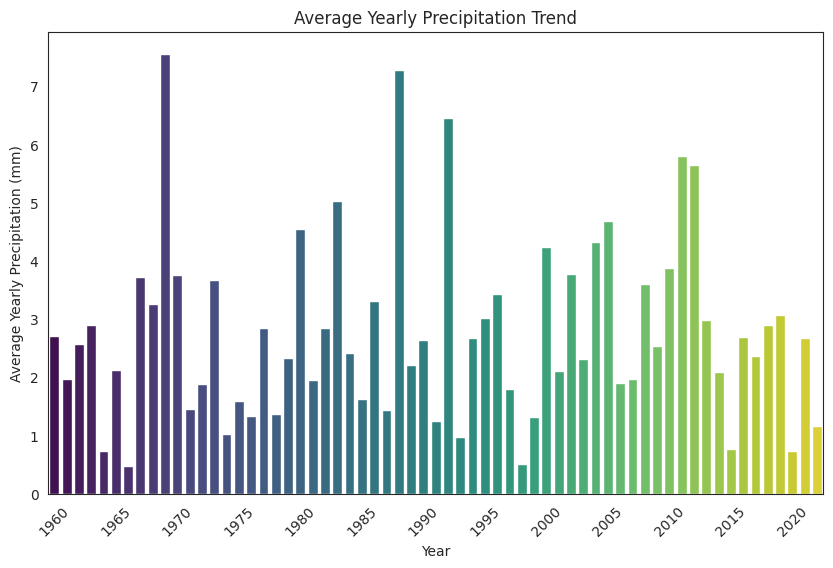

In [14]:
average_yearly_precip = df.groupby('Year')['daily_precipitation (mm)'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='daily_precipitation (mm)', data=average_yearly_precip, palette='viridis')
plt.title('Average Yearly Precipitation Trend')
plt.xlabel('Year')
plt.ylabel('Average Yearly Precipitation (mm)')

step = 5
plt.xticks(range(0, len(average_yearly_precip), step), average_yearly_precip['Year'][::step], rotation=45)

plt.show()


### Results Summary:

Using these visualizations there are a few conclusions that we can make. First of all, the average temperature has a relatively standard pattern that it follows, almost like a sine wave. We can also tell that the lowest average temperature on the weeks of July 15th - July 31st from 1960 to 2022 was 1991 and the highest was 1999. The precipitation graph is much more interesting however, as there is a much wider difference in results. We can see that 1969 had the greatest amount of precipitation while 1966 or 1998 had the lowest. There isnt much of a pattern or trend in this graph like there is with the temperature graph.